In [1]:
!cat /etc/*-release
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

DISTRIB_ID=Ubuntu
DISTRIB_RELEASE=18.04
DISTRIB_CODENAME=bionic
DISTRIB_DESCRIPTION="Ubuntu 18.04.3 LTS"
NAME="Ubuntu"
VERSION="18.04.3 LTS (Bionic Beaver)"
ID=ubuntu
ID_LIKE=debian
PRETTY_NAME="Ubuntu 18.04.3 LTS"
VERSION_ID="18.04"
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
VERSION_CODENAME=bionic
UBUNTU_CODENAME=bionic


# GPU details

In [2]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=1a355c4d159cb1dc84078ebd20e92d48976cdd3728e46799229dc4c0f5480393
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 26.4 GB  | Proc size: 156.5 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [3]:
# Step 1
# Run only once
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
# Installing libraries
!pip install nltk
!pip install torch

# Task 1: Loading and observing data ( 5 min )
## Loading dataset
In this case, yelp dataset is in JSON format but it is not in correct format to be able to be loaded into dataframe. Some transformations are applied before it is loaded in the dataframe. As one line is seperated from the other by `\n`. It is removed and replaced with `,` and then `[]` brackets are added to the start and end to make it a list of dictionaries which is a valid json format. For faster execution of rest of the steps, only top 100000 rows are taken. `reviews.json` file from Yelp JSON Dataset is used as input. Output of this is copied to CodePub Folder and used in the next steps, hence this block does not need to be run as it takes long time and the original file is not shared in the folder to avoid space issue.   

In [0]:
########## DO NOT RUN THIS BLOCK ############
# If notebook fails to run this because of load, try running it locally
# Yelp Restaurant Reviews
import pandas as pd

def load_yelp_orig_data():
    PATH_TO_YELP_REVIEWS = '/content/drive/My Drive/CodePub/review.json'

    # read the entire file into a python array
    with open(PATH_TO_YELP_REVIEWS, 'r') as f:
        data = f.readlines()

    # remove the trailing "\n" from each line
    data = map(lambda x: x.rstrip(), data)

    data_json_str = "[" + ','.join(data) + "]"

    # now, load it into pandas
    data_df = pd.read_json(data_json_str)

    data_df.head(100000).to_csv('/content/drive/My Drive/CodePub/output_reviews_top.csv')

# load_yelp_orig_data()

## Set the Input and Output Directories


In [0]:
# Step 2
INPUT_FOLDER = '/content/drive/My Drive/CodePub/'
# Change the output_folder to your choice ( '/content/drive/My Drive/CodePub/' )
OUTPUT_FOLDER = '/content/drive/My Drive/CodePub/'

Only the top 100000 rows are loaded in pandas dataframe. This data will be used in the next steps. 

In [6]:
# Step 3
import pandas as pd
top_data_df = pd.read_csv(INPUT_FOLDER + 'output_reviews_top.csv')
top_data_df.columns

Index(['Unnamed: 0', 'business_id', 'cool', 'date', 'funny', 'review_id',
       'stars', 'text', 'useful', 'user_id'],
      dtype='object')

# Basic Statistics
`Stars` is a column chosen to determine the sentiment of the review text. As the stars are from 1 to 5. Stars `1-2` are considered `negative` review, Star rating of `3` is considered `neutral` and rating `>3` are considered positive. The goal of this workshop would be to try different classification methods for classifying the reviews into these three sentiments to get accurate classifications.

As it is visible from the chart, the number of rows for each review are not equal. This is quite possible in real-world problems. We will have to adapt the model to be able to capture the sentiments accurately even with these kind of conditions. 

Number of rows per star rating:
5    44367
4    22103
1    14585
3    10970
2     7975
Name: stars, dtype: int64

Top 10 rows: 

   Unnamed: 0             business_id  ...                 user_id sentiment
0           0  ujmEBvifdJM6h6RLv4wQIg  ...  hG7b0MtEbXx5QzbzE6C_VA        -1
1           1  NZnhc2sEQy3RmzKTZnqtwQ  ...  yXQM5uF2jS6es16SJzNHfg         1
2           2  WTqjgwHlXbSFevF32_DJVw  ...  n6-Gk65cPZL6Uz8qRm3NYw         1
3           3  ikCg8xy5JIg_NGPx-MSIDA  ...  dacAIZ6fTM6mqwW5uxkskg         1
4           4  b1b1eb3uo-w561D0ZfCEiQ  ...  ssoyf2_x0EQMed6fgHeMyQ        -1
5           5  eU_713ec6fTGNO4BegRaww  ...  w31MKYsNFMrjhWxxAb5wIw         1
6           6  3fw2X5bZYeW9xCz_zGhOHg  ...  jlu4CztcSxrKx56ba1a5AQ         0
7           7  zvO-PJCpNk4fgAVUnExYAA  ...  d6xvYpyzcfbF_AZ8vMB7QA        -1
8           8  b2jN2mm9Wf3RcrZCgfo1cg  ...  sG_h0dIzTKWa3Q6fmb4u-g        -1
9           9  oxwGyA17NL6c5t1Etg5WgQ  ...  nMeCE5-xsdleyxYuNZ_7rA         0

[10 rows x 11 columns]


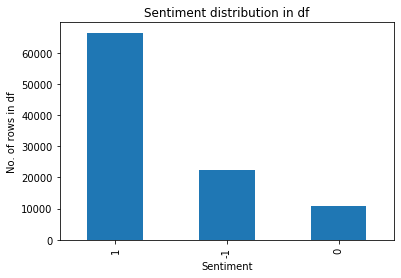

After segregating and taking equal number of rows for each sentiment:
-1    5000
 1    5000
 0    5000
Name: sentiment, dtype: int64


,Unnamed: 0,business_id,cool,date,funny,review_id,stars,text,useful,user_id,sentiment
1,1,NZnhc2sEQy3RmzKTZnqtwQ,0,2017-01-14 21:30:33,0,GJXCdrto3ASJOqKeVWPi6Q,5,I *adore* Travis at the Hard Rock's new Kelly ...,0,yXQM5uF2jS6es16SJzNHfg,1
2,2,WTqjgwHlXbSFevF32_DJVw,0,2016-11-09 20:09:03,0,2TzJjDVDEuAW6MR5Vuc1ug,5,I have to say that this office really has it t...,3,n6-Gk65cPZL6Uz8qRm3NYw,1
3,3,ikCg8xy5JIg_NGPx-MSIDA,0,2018-01-09 20:56:38,0,yi0R0Ugj_xUx_Nek0-_Qig,5,Went in for a lunch. Steak sandwich was delici...,0,dacAIZ6fTM6mqwW5uxkskg,1
5,5,eU_713ec6fTGNO4BegRaww,0,2013-01-20 13:25:59,0,fdiNeiN_hoCxCMy2wTRW9g,4,I'll be the first to admit that I was not exci...,0,w31MKYsNFMrjhWxxAb5wIw,1
10,10,8mIrX_LrOnAqWsB5JrOojQ,0,2011-11-30 02:11:15,0,kbtscdyz6lvrtGjD1quQTg,4,"Like walking back in time, every Saturday morn...",0,FIk4lQQu1eTe2EpzQ4xhBA,1
12,12,FxLfqxdYPA6Z85PFKaqLrg,0,2016-05-07 01:36:53,0,Z7wgXp98wYB57QdRY3HQ3w,4,Wow. So surprised at the one and two star revi...,0,GYNnVehQeXjty0xH7-6Fhw,1
13,13,LUN6swQYa4xJKaM_UEUOEw,0,2018-04-27 20:25:26,0,qlXw1JQ0UodW7qrmVgwCXw,4,Michael from Red Carpet VIP is amazing ! I rea...,0,bAhqAPoWaZYcyYi7bs024Q,1
15,15,YvrylyuWgbP90RgMqZQVnQ,0,2017-04-07 21:27:49,0,svK3nBU7Rk8VfGorlrN52A,5,You can't really find anything wrong with this...,0,NJlxGtouq06hhC7sS2ECYw,1
16,16,NyLYY8q1-H3hfsTwuwLPCg,0,2015-01-03 22:47:34,0,1wVA2-vQIuW_ClmXkDxqMQ,4,Great lunch today. Staff was very helpful in a...,0,86J5DwcFk4f4In1Vxe2TvA,1
18,18,6lj2BJ4tJeu7db5asGHQ4w,0,2017-05-26 01:23:19,0,rEITo90tpyKmEfNDp3Ou3A,5,We've been a huge Slim's fan since they opened...,0,6Fz_nus_OG4gar721OKgZA,1


In [8]:
# Step 4
import matplotlib.pyplot as plt 

print("Number of rows per star rating:")
print(top_data_df['stars'].value_counts())
print("\nTop 10 rows: \n")
print(top_data_df.head(10))

# Function to map stars to sentiment
def map_sentiment(stars_received):
    if stars_received <= 2:
        return -1
    elif stars_received == 3:
        return 0
    else:
        return 1
# Mapping stars to sentiment into three categories
top_data_df['sentiment'] = [ map_sentiment(x) for x in top_data_df['stars']]
# Plotting the sentiment distribution
plt.figure()
pd.value_counts(top_data_df['sentiment']).plot.bar(title="Sentiment distribution in df")
plt.xlabel("Sentiment")
plt.ylabel("No. of rows in df")
plt.show()

# Function to retrieve top few number of each category
def get_top_data(top_n = 5000):
    # 5000 is used for basic models and for CNN 10,000 top items are used
    top_data_df_positive = top_data_df[top_data_df['sentiment'] == 1].head(top_n)
    top_data_df_negative = top_data_df[top_data_df['sentiment'] == -1].head(top_n)
    top_data_df_neutral = top_data_df[top_data_df['sentiment'] == 0].head(top_n)
    top_data_df_small = pd.concat([top_data_df_positive, top_data_df_negative, top_data_df_neutral])
    return top_data_df_small

# Function call to get the top 5000 from each sentiment
top_data_df_small = get_top_data(top_n=5000)

# After selecting top few samples of each sentiment
print("After segregating and taking equal number of rows for each sentiment:")
print(top_data_df_small['sentiment'].value_counts())
top_data_df_small.head(10)

# Task 2: Normalizing Data ( 10 min )
## Ways of Normalizing Text

Removing stop words, lemmatization and/or stemming are common ways of cleaning the text and normalizing it to reduce the number of tokens used as input and get the relevant information from the text. Language as we know is made of the words derived from each other or is often conjugated with different suffixes or prefixes for different reasons in grammar. Some of the words are just supporting words so might not add much to actual intention of the sentence. Hence, we implement various techniques to get a better input to the model. 

### 1.   **Removing Stop Words**

Text would have lot of stop words which does help the model for most of the text related ML cases but in sentiment analysis this would not be useful as the stop words makes the statement positive and negative and adds the weight to the sentiment ( words like really, too, etc.) so if those words are removed it would be hard to get the correct sentiment. This is a good example to understand that one has to choose the cleaning steps very carefully. One of the examples of how removing the stop words would make it difficult is shown in the below example. Removing the stop words can be achieved with creating a custom list of stop words manually or by using existing library which removes the common stop words in the english language. Libraries like spacy, gensim and nltk have those functions to remove stop words. Example is given for gensim library.

In [10]:
# Removing the stop words
from gensim.parsing.preprocessing import remove_stopwords
print(remove_stopwords("Restaurant  had a really good service!!"))
print(remove_stopwords("I did not like the food!!"))
print(remove_stopwords("This product is not good!!"))
# Task Stop Words: Uncomment following 2 sentences and fill in the correct info to remove stop words from your own statement
sentence = "this restaurant is not what I thought it would be"
print(remove_stopwords(sentence))

## As we are not implementing this for our data, this is not applied to the column 'text'

Restaurant good service!!
I like food!!
This product good!!
restaurant I thought


### 2. **Stemming**
Stemming is used to get the word form to it's root form by removing the suffixes/prefixes if added any. Stemming gets the words to the reduced form but some of the reduced forms might not be real words as well. 

Stemming example: 

*Orignal* -> *Stemmed word*

**Ponies** -> **Poni**

**Learned** -> **Learn**

**compute** -> **comput**

There are different algorithms used to do the stemming. PorterStammer(1979),LancasterStammer (1990), and SnowballStemmer ( can add custom rules). NLTK or gensim package can be used for implementing these algorithms for stemming. Lancaster is bit slower than Porter so we can use it according to size and response time required. Snowball stemmer is a slightly improved version of the Porter stemmer and is usually preferred over the latter. Examples have been used to compare the two below. As for this case, no custom rules are added and the results show that porter works fine and as it is simple and speedy to use, that is used in further steps. It is used in the next steps. It is not very clear which one will produce accurate results, those two can be compared in the classification models. 

Stemming is widely used in the application of SEOs, Web search results, and information retrieval since as long as the root matches in the text somewhere it helps to retrive all the related documents in the search.

In [14]:
# Step 5
# Example of Porter stemming
from gensim.parsing.porter import PorterStemmer
import nltk

# Uncomment the following for the first time run
# nltk.download('stopwords')
porter_stemmer = PorterStemmer()
stemmer_example = "Wow the food was not really delicious Seasoned Spicy sour and yummy ! It's not worth a try for sure."
print("Porter Algorithm:")
print(porter_stemmer.stem_sentence(stemmer_example))
# use p.stem(word) for applying to each word

# Example of Snowball stemmer
from nltk.stem.snowball import SnowballStemmer

# Option to ignore the stop words
# stemmer = SnowballStemmer(language='english', ignore_stopwords=True)
snowball_stemmer = SnowballStemmer(language='english')
print("\nSnowball Algorithm:")
print(" ".join([snowball_stemmer.stem(word) for word in stemmer_example.split(" ")]))

# Task Stemming: Uncomment following all sentences and fill in the new sentence and correct object names
# print("\nTask output: ")
# stemmer_task_example = ""
# print(porter_stemmer.stem_sentence(stemmer_task_example))
# print(" ".join([snowball_stemmer.stem(word) for word in stemmer_task_example.split(" ")]))

Porter Algorithm:
wow the food wa not realli delici season spici sour and yummi ! it' not worth a try for sure.

Snowball Algorithm:
wow the food was not realli delici season spici sour and yummi ! it not worth a tri for sure.


### Example of how the stemmer is applied to dataframe column

In [0]:
# Porter is used in this use case.
# Create a new column with stemmed sentence
top_data_df['stemmed_sentence'] = [porter_stemmer.stem_sentence(sentence) for sentence in top_data_df['text']]
# Print the top two sentences to see the changes in the sentence
i = 0
for index, row in top_data_df.iterrows():
    i += 1
    print("Row No:" + str(index+1))
    print("Original text:")
    print(row['text'])
    print("\n")
    print("Stemmed text:")
    print(row['stemmed_sentence'])
    print("\n\n")
    if i == 2:
        break

Row No:1
Original text:
Total bill for this horrible service? Over $8Gs. These crooks actually had the nerve to charge us $69 for 3 pills. I checked online the pills can be had for 19 cents EACH! Avoid Hospital ERs at all costs.


Stemmed text:
total bill for thi horribl service? over $8gs. these crook actual had the nerv to charg us $69 for 3 pills. i check onlin the pill can be had for 19 cent each! avoid hospit er at all costs.



Row No:2
Original text:
I *adore* Travis at the Hard Rock's new Kelly Cardenas Salon!  I'm always a fan of a great blowout and no stranger to the chains that offer this service; however, Travis has taken the flawless blowout to a whole new level!  

Travis's greets you with his perfectly green swoosh in his otherwise perfectly styled black hair and a Vegas-worthy rockstar outfit.  Next comes the most relaxing and incredible shampoo -- where you get a full head message that could cure even the very worst migraine in minutes --- and the scented shampoo room.

### 3. **Lemmatization**
Stemming does get the root words but with disregard to it's actual presence in the language. Lemmatization is on the other hand reduces the word to it's canonical form or dictionary form or citation form of set of words ([lemma](https://www.datacamp.com/community/tutorials/stemming-lemmatization-python)).

**are, is** -> **be**


**stood** -> **stand**

Spacy, NLTK, or gensim modules can be used for doing lemmatization. Here, nltk example is shown how it will work. Punctuation marks have to be removed for lemmatization to work. For lemmatization to work properly, we need to apply part of speech tags. For this experiment, we will stick to the stemming method. 


In [11]:
import nltk
# Uncomment following for the first time running this cell
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

lemma_example_1 = "Previously their waiters spoke very politely. Now it is not the same!"
lemma_example_2 = "Waiters in this restaurant speak politely."

# Without part of speech
print("Without POS:")
print ([ wordnet_lemmatizer.lemmatize(word) for word in lemma_example_1.split(" ")])
print ([ wordnet_lemmatizer.lemmatize(word) for word in lemma_example_2.split(" ")])

# With part of speech
## Get the part of speech mapping to give the pos parameter to the lemmatize function
print("\nPOS using NLTK for sample sentence:")
print(nltk.pos_tag(lemma_example_1.split(" ")))
def get_wordnet_mapping_pos(lemma_example_1):
    """Map POS tag to first character wordnet_lemmatizer() accepts"""
    tag_array = []
    for word_tag in nltk.pos_tag(lemma_example_1.split(" ")):
        tag = word_tag[1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}

        tag_array.append((word_tag[0], tag_dict.get(tag, wordnet.NOUN)))
    return tag_array

print("\nWith POS:")
print( [wordnet_lemmatizer.lemmatize(word, tag) for word, tag in get_wordnet_mapping_pos(lemma_example_1)])
print( [wordnet_lemmatizer.lemmatize(word, tag) for word, tag in get_wordnet_mapping_pos(lemma_example_2)])
print([wordnet_lemmatizer.lemmatize(word, 'v') for word in lemma_example_1.split(" ")])

# Task Lemmatization: Uncomment the following and fill in the new sentence to get the lemmatized version
print("\nLemmatization Task:\n")
lemma_task_example = ""
print( [wordnet_lemmatizer.lemmatize(word, tag) for word, tag in get_wordnet_mapping_pos(lemma_task_example)])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
Without POS:
['Previously', 'their', 'waiter', 'spoke', 'very', 'politely.', 'Now', 'it', 'is', 'not', 'the', 'same!']
['Waiters', 'in', 'this', 'restaurant', 'speak', 'politely.']

POS using NLTK for sample sentence:
[('Previously', 'RB'), ('their', 'PRP$'), ('waiters', 'NNS'), ('spoke', 'VBD'), ('very', 'RB'), ('politely.', 'RB'), ('Now', 'RB'), ('it', 'PRP'), ('is', 'VBZ'), ('not', 'RB'), ('the', 'DT'), ('same!', 'NN')]

With POS:
['Previously', 'their', 'waiter', 'speak', 'very', 'politely.', 'Now', 'it', 'be', 'not', 'the', 'same!']
['Waiters', 'in', 'this', 'restaurant', 'speak', 'politely.']
['Previously', 'thei

# Task 3: Preparing Data ( 5 min )
## Tokenizing the text

There are different ways to tokenize depending on the use case at hand. `tokenize` function ([tokenize](https://radimrehurek.com/gensim/utils.html#gensim.utils.tokenize)) in the gensim library can be used to tokenize which replaces the special characters, removes extra spaces. One level up is the `simple_preprocess` function ([utils](https://radimrehurek.com/gensim/utils.html)) which goes one step further to make it lowercase and ignore the words as per mentioned in the min and max length. ( Filtering the words that would be potentially rare or stop words). 

In [12]:
# Step 6
from gensim.utils import tokenize
from gensim.utils import simple_preprocess
import re

## Different ways of preprocessing the text

# Custom cleaning
# This is an example how it will be applied to column in dataframe
# top_data_df['custom_tokens'] = [re.sub(' +', ' ', line).strip().split(" ") for line in top_data_df['text']] 
line = "Restaurant  had a really good service!!"
print("Spliting line by space:")
################### OPTION 1 #######################
print( line.split(" "))
print("Custom regex for handling space and stripping end spaces:")
################### OPTION 2 #######################
print( re.sub(' +', ' ', line).strip().split(" "))

# Using tokenize function for tokenizing
# This is an example of hwo the tokenize function will be applied to a column in a dataframe
# top_data_df['tokenized_text_with_tokenize'] = [list(tokenize(line, deacc=True)) for line in top_data_df['text']] 
print("Gensim tokenize function: ")
################### OPTION 3 #######################
print(list(tokenize(line, deacc=True)))


print("Gensim simple preprocess")
################### OPTION 4 #######################
print(simple_preprocess(line, deacc=True))
# Running this for the dataframe as this will be used for next steps
top_data_df_small['tokenized_text'] = [simple_preprocess(line, deacc=True) for line in top_data_df_small['text']] 
print(top_data_df_small['tokenized_text'].head(10))

# Task Tokenization: Use one of your fav methods above and tokenize your own setnence
print("Task Tokenization:")
token_task_sentence = "Food totally #blew my mind!!!! "
print(list(tokenize(token_task_sentence, deacc=True))) 

Spliting line by space:
['Restaurant', '', 'had', 'a', 'really', 'good', 'service!!']
Custom regex for handling space and stripping end spaces:
['Restaurant', 'had', 'a', 'really', 'good', 'service!!']
Gensim tokenize function: 
['Restaurant', 'had', 'a', 'really', 'good', 'service']
Gensim simple preprocess
['restaurant', 'had', 'really', 'good', 'service']
1     [adore, travis, at, the, hard, rock, new, kell...
2     [have, to, say, that, this, office, really, ha...
3     [went, in, for, lunch, steak, sandwich, was, d...
5     [ll, be, the, first, to, admit, that, was, not...
10    [like, walking, back, in, time, every, saturda...
12    [wow, so, surprised, at, the, one, and, two, s...
13    [michael, from, red, carpet, vip, is, amazing,...
15    [you, can, really, find, anything, wrong, with...
16    [great, lunch, today, staff, was, very, helpfu...
18    [we, ve, been, huge, slim, fan, since, they, o...
Name: tokenized_text, dtype: object
Task Tokenization:
['Food', 'totally', 'ble

After getting the tokens, stemming is applied. As stemming would work on the words without the special characters. This is the best place to apply stemming. 

In [15]:
# Step 7
# Get the stemmed_tokens required for next steps
top_data_df_small['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in tokens] for tokens in top_data_df_small['tokenized_text'] ]
top_data_df_small['stemmed_tokens'].head(10)

1     [ador, travi, at, the, hard, rock, new, kelli,...
2     [have, to, sai, that, thi, offic, realli, ha, ...
3     [went, in, for, lunch, steak, sandwich, wa, de...
5     [ll, be, the, first, to, admit, that, wa, not,...
10    [like, walk, back, in, time, everi, saturdai, ...
12    [wow, so, surpris, at, the, on, and, two, star...
13    [michael, from, red, carpet, vip, is, amaz, re...
15    [you, can, realli, find, anyth, wrong, with, t...
16    [great, lunch, todai, staff, wa, veri, help, i...
18    [we, ve, been, huge, slim, fan, sinc, thei, op...
Name: stemmed_tokens, dtype: object

In [0]:
# Step 8
# Function to preprocess the data when dataframe is changed
from gensim.utils import simple_preprocess
from gensim.parsing.porter import PorterStemmer
porter_stemmer = PorterStemmer()
def get_stemmed_tokens(top_data_df_small):
    top_data_df_small['tokenized_text'] = [simple_preprocess(line, deacc=True) for line in top_data_df_small['text']]
    top_data_df_small['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in tokens] for tokens in top_data_df_small['tokenized_text'] ]
    return top_data_df_small
# top_data_df_small = get_stemmed_tokens(top_data_df_small)


# Dictionary
Each unique word would be identified by an unique id in the dictionary object. This needs to be created for creating representations of texts. Bag of Words corpus is created using this. This will be useful to get the corresponding word for the given unique id. Dictionary is created by list of words. Sentences/documents etc. can be converted to list of words and then fed to the `corpora.Dictionary` as a parameter. 

In [17]:
# Step 9
from gensim import corpora
# Function to return the dictionary either with padding word or without padding
def make_dict(top_data_df_small, padding=True):
    if padding:
        print("Dictionary with padded token added")
        mydict = corpora.Dictionary([['pad']])
        mydict.add_documents(top_data_df_small['stemmed_tokens'])
    else:
        print("Dictionary without padding")
        mydict = corpora.Dictionary(top_data_df_small['stemmed_tokens'])
    return mydict

# Make the dictionary without padding for the basic models ( Padding is required for CNN )
mydict = make_dict(top_data_df_small, padding=False)


Dictionary without padding


In [18]:
# Getting the mapping from word to unique id
from collections import Counter
d= Counter(mydict.token2id)
print(d.most_common()[:10])
print(len(mydict.token2id))

[('swimwear', 21811), ('carveri', 21810), ('daintili', 21809), ('littleweird', 21808), ('zzeek', 21807), ('forefath', 21806), ('gaspworthi', 21805), ('corps', 21804), ('poki', 21803), ('spink', 21802)]
21812


# Bag of Words

Bag of Words (BOW) is one way of modeling text data for machine learning. This is the basic form of representing the text in numbers. Tokenized sentence is represented by an array of frequency of each word from the dictionary in the sentence. 

Example: 
Documents:
1. This restaurant was great. Food was great too.
2. Restaurant served different kinds of food.

Let the words in the sequence be


Words: this, restaurant, was, great, food, too, served, different, kinds, of

Sent 1 [ 1, 1, 2, 2, 2, 1, 0, 0, 0, 0]

Sent 2 [ 0, 1, 0, 0, 1, 0, 1, 1, 1, 1]

These will be the bow vectors if those 2 documents were present in the corpus. Number of words in the corpus will be the number of features for the machine learning model. This vectors will be fed as input to the model for prediction. 

BOW vector can be calculated using [Scikit-learn package's CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) or using  [Gensim library's doc2bow](https://radimrehurek.com/gensim/corpora/dictionary.html).


In [19]:
import gensim
vocab_len = len(mydict)
print("Example of how the BOW words")
arr = []
for line in top_data_df_small['stemmed_tokens']:
    print("Doc2Bow Line:")
    print(mydict.doc2bow(line))
    for word in line:
        arr.append(mydict.token2id[word])
    print("Actual line:")
    print(line)
    print("(Word, count) Tuples:")
    print([(mydict[id], count) for id, count in mydict.doc2bow(line) ])
    print("Sparse bow vector for the line")
    print(gensim.matutils.corpus2csc([mydict.doc2bow(line)],num_terms=vocab_len).toarray()[:,0])
    break
print("Sorted word id list")
print(sorted(arr))

Example of how the BOW words
Doc2Bow Line:
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 9), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 5), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 2), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 3), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 3), (61, 1), (62, 4), (63, 1), (64, 1), (65, 2), (66, 1), (67, 1), (68, 3), (69, 1), (70, 5), (71, 1), (72, 1), (73, 1), (74, 5), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 2), (81, 2), (82, 2), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 3), (89, 2), (90, 2), (91, 1), (92, 3), (93, 1), (94, 4), (95, 1), (96, 2), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 3), (106, 

# Splitting the data into train and test

Train data would be used to train the model and test data is the data on which the model would predict the classes and it will be compared with original labels to check the accuracy or other model test metrics. 

- Train data ( Subset of data for training ML Model) ~70%
- Test data (Subset of data for testing ML Model trained from the train data) ~30%

It is important to make sure that both subsets represent whole of the data. Both should have similar characteristics. One set should not be different from others. Try to balance the number of classes in both the sets so that the results are not biased or one of the reasons for insufficient model training. This is a crucial part of machine learning model. In real-world problems, there are cases of imbalanced classes which needs using techniques like oversampling minority class, undesampling majority class ([Resample function from scikit-learn packaged](https://scikit-learn.org/stable/modules/generated/sklearn.utils.resample.html) or generating synthetic samples using [SMOTE functionality in Imblearn package](https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html#smote-variants) . This uses nearest neighbors algorithm for generating new and synthetic data that can be used for training. 

For this case, the data is split into two parts, train and test with 70% in train and 30% in test. While making the splitting, it is better to have equal distribution of classes in both train and test data. Here, function  [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) from scikit-learn package is used. 

See the visualization of splitting of data:
[Google ML Guide](https://developers.google.com/machine-learning/crash-course/training-and-test-sets/splitting-data)


In [20]:
# Step 10
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
# Train Test Split Function
def split_train_test(top_data_df_small, test_size=0.3, shuffle_state=True):
    X_train, X_test, Y_train, Y_test = train_test_split(top_data_df_small[['business_id', 'cool', 'date', 'funny', 'review_id', 'stars', 'text', 'useful', 'user_id', 'stemmed_tokens']], 
                                                        top_data_df_small['sentiment'], 
                                                        shuffle=shuffle_state,
                                                        test_size=test_size, 
                                                        random_state=15)
    print("Value counts for Train sentiments")
    print(Y_train.value_counts())
    print("Value counts for Test sentiments")
    print(Y_test.value_counts())
    print(type(X_train))
    print(type(Y_train))
    X_train = X_train.reset_index()
    X_test = X_test.reset_index()
    Y_train = Y_train.to_frame()
    Y_train = Y_train.reset_index()
    Y_test = Y_test.to_frame()
    Y_test = Y_test.reset_index()
    print(X_train.head())
    return X_train, X_test, Y_train, Y_test

# Call the train_test_split
X_train, X_test, Y_train, Y_test = split_train_test(top_data_df_small)

Value counts for Train sentiments
-1    3526
 1    3492
 0    3482
Name: sentiment, dtype: int64
Value counts for Test sentiments
 0    1518
 1    1508
-1    1474
Name: sentiment, dtype: int64
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
   index  ...                                     stemmed_tokens
0   5635  ...  [my, mom, is, from, malaysia, and, we, rare, g...
1   8177  ...  [overpr, food, thi, pizza, doesn, worth, it, t...
2   3056  ...  [hidden, treasur, of, rock, hill, kind, of, st...
3   5008  ...  [big, thank, to, hq, pizzavil, for, help, me, ...
4   5097  ...  [had, great, experi, we, ar, sell, our, home, ...

[5 rows x 11 columns]


# Task 4: Classification using BOW ( 5 min )

## Creating BOW vectors for train data

BOW vectors when created by gensim package are dense. That is the output is in the form of `[(word_id, freq), (word_id, freq), ...]` where this `word_id` is the id for the word in the dictionary and the frequency is the number of times the word appears in the sentence. This vector is only for the words in the sentence. For model training, a sparse matrix needs to be created. That is a vector with length equal to length of vocab in the dictionary and setting it zeros where the words are not present in the sentence. That is created using corpus2csc ([doc](https://tedboy.github.io/nlps/generated/generated/gensim.matutils.corpus2csc.html)). Doc2bow converts the `stemmed_tokens` into dense vectors and corpus2csc converts it into sparse so it can be used for training and the index of the vector is the word id in dictionary. This is used to give headers of the columns with actual word so that the features can be recognized properly. 

Training data is iterated through to wrote the BOW vectors to a csv file below. Header is printed which shows all the words in the dictionary.

In [0]:
import gensim
import time
start_time = time.time()
vocab_len = len(mydict)
# bow_filename = '/content/drive/My Drive/CodePub_Local/trained_data/train_review_bow.csv'
bow_filename = OUTPUT_FOLDER + 'trained_data/' + 'train_review_bow.csv'
with open(bow_filename, 'w+') as bow_file:
    for index, row in X_train.iterrows():
        features = gensim.matutils.corpus2csc([mydict.doc2bow(row['stemmed_tokens'])],num_terms=vocab_len).toarray()[:,0]
        if index == 0:
            print("Header")
            header = ",".join(str(mydict[ele]) for ele in range(vocab_len))
            print(header)
            bow_file.write(header)
            bow_file.write("\n")
        line1 = ",".join( [str(vector_element) for vector_element in features] )
        bow_file.write(line1)
        bow_file.write('\n')

print("Time taken to create bow for :" + str(time.time() - start_time))

Header
action,admir,ador,all,along,also,alwai,amount,and,anoth,around,as,at,awesom,be,beauuuuti,befor,best,better,black,blowout,bouncei,brush,but,cardena,chain,clearli,come,corpor,could,cure,dai,didn,do,end,even,ever,everi,evid,extrem,fan,feel,finger,flat,flawless,flip,for,freakishli,from,fry,full,fun,genuin,get,girl,gloriou,good,great,green,greet,ha,had,hair,happen,hard,he,head,help,hi,howev,in,incred,involv,iron,it,kelli,last,less,level,like,look,make,me,messag,migrain,minut,most,much,my,new,next,no,not,note,of,offer,on,onli,otherwis,out,outfit,over,pagent,peopl,perfect,perfectli,pressur,realli,relax,requir,rock,rockstar,room,round,salon,scent,see,seen,servic,shampoo,singl,skill,so,some,someth,start,stranger,strong,style,stylist,superb,swoosh,taken,talk,team,terrif,texa,that,the,thei,then,there,thi,thing,three,time,to,travi,two,us,ve,vega,veri,volum,wa,wai,well,were,where,whole,will,with,without,worst,worth,worthi,wrist,you,about,amaz,ar,assist,bailei,can,care,comfort,credit,dental,d

In [22]:
import pandas as pd
bow_df = pd.read_csv(OUTPUT_FOLDER + 'trained_data/' + 'train_review_bow.csv')
print(bow_df.head(10))

   action  admir  ador  all  ...  littleweird  daintili  carveri  swimwear
0     0.0    0.0   0.0  0.0  ...          0.0       0.0      0.0       0.0
1     0.0    0.0   0.0  0.0  ...          0.0       0.0      0.0       0.0
2     0.0    0.0   0.0  0.0  ...          0.0       0.0      0.0       0.0
3     0.0    0.0   0.0  0.0  ...          0.0       0.0      0.0       0.0
4     0.0    0.0   0.0  0.0  ...          0.0       0.0      0.0       0.0
5     0.0    0.0   0.0  0.0  ...          0.0       0.0      0.0       0.0
6     0.0    0.0   0.0  0.0  ...          0.0       0.0      0.0       0.0
7     0.0    0.0   0.0  0.0  ...          0.0       0.0      0.0       0.0
8     0.0    0.0   0.0  0.0  ...          0.0       0.0      0.0       0.0
9     0.0    0.0   0.0  0.0  ...          0.0       0.0      0.0       0.0

[10 rows x 21812 columns]


# Decision Tree Classifier with BOW

Decision tree classifier is Supervised Machine learning algorithm for classification. Decision tree consists of nodes, edges and  leaf nodes. Leaf nodes are the one deciding the class. This is built using binary recursive partioning. Attribute selection measure which is heuristic is used to split the records at each stage of splitting. It gives rank to each feature and accordingly chooses the feature. Most popular measures are Information Gain, Gain Ratio, and Gini Index. In this example, scikit-learn package is used for implementing the [decision tree classifier class](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). Criterion paramter is used to set this measure. By default "Gini" is used. 
The goal of the splitting measure is to detect the most important features to be near the root and traversing down by splitting the nodes. The level of impurity decreases as we go down the tree. 


Gini Index measures the probability of a particular instance being wrongly labeled when it is randomly chosen. If all the elements in the group are classified in the same class then that is called pure. Impurity is the opposite of that situation, that the set is consisting of different classes. Value of Gini index varies from 0 to 1. 0 is pure and 1 signifies that the class distribution is random amongst the elements. Hence, while building the decision tree, feature with the least gini index is chosen for splitting. It is computatioanlly less intensive compared to Information Gain as it does not involve logarithms. Useful for faster training ( [Decision tree classifier](https://blog.quantinsti.com/gini-index/)). 

Process:
1. Train the classifier model with the `fit` function.
2. Use the model to predict the test data lables.
3. Check the performance of the model using [classification report function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html). This function gives the precision, recall, f1-score and support for each class labels and gives the averaged accuracy as well. This can be used to compare different models in future. 



In [23]:
from sklearn.tree import DecisionTreeClassifier
import time
# Train the classifier with default parameters
start_time = time.time()
clf = DecisionTreeClassifier(random_state=0)
# Group 1 Task: Uncomment following line and comment the above line
# clf = DecisionTreeClassifier(max_features=500, criterion='entropy')
# Group 2 Task: Uncomment following line and comment the top classifier line
# clf = DecisionTreeClassifier(max_features=1000, criterion='entropy')
# Group 3 Task: Uncomment following line and comment the top classifier line
# clf = DecisionTreeClassifier(max_features=2000, criterion='gini')
clf.fit(bow_df, Y_train['sentiment'])
print("Time taken to fit the model: " + str(time.time() - start_time))

Time taken to fit the model: 10.95554518699646


In [24]:
# Find out the most important features from the bow classification model
importances = list(clf.feature_importances_)
feature_importances = [(feature, round(importance, 10)) for feature, importance in zip(bow_df.columns, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# print(feature_importances)
top_i = 0
for pair in feature_importances:
    print('Variable: {:20} Importance: {}'.format(*pair))
    if top_i == 20:
        break
    top_i += 1

Variable: not                  Importance: 0.0388773101
Variable: great                Importance: 0.0324062928
Variable: but                  Importance: 0.0320342191
Variable: good                 Importance: 0.0280112025
Variable: amaz                 Importance: 0.0165604982
Variable: never                Importance: 0.0143632584
Variable: delici               Importance: 0.0142258021
Variable: love                 Importance: 0.0141690332
Variable: friendli             Importance: 0.0097266015
Variable: the                  Importance: 0.0091863422
Variable: worst                Importance: 0.0089672744
Variable: and                  Importance: 0.0085211447
Variable: told                 Importance: 0.0085111227
Variable: wa                   Importance: 0.0082645404
Variable: to                   Importance: 0.007870564
Variable: rude                 Importance: 0.0078331741
Variable: best                 Importance: 0.0077612715
Variable: for                  Importance: 0.0076

In [25]:
# Iterating through test data to get the predictions of sentiment by the model
test_features = []
start_time = time.time()
for index, row in X_test.iterrows():
    # Converting the tokens into the formet that the model requires
    features = gensim.matutils.corpus2csc([mydict.doc2bow(row['stemmed_tokens'])],num_terms=vocab_len).toarray()[:,0]
    test_features.append(features)
test_predictions = clf.predict(test_features)
# Comparing the predictions to actual sentiments for the sentences
print(classification_report(Y_test['sentiment'],test_predictions))
print("Time taken to predict the model " + str(time.time() - start_time))

              precision    recall  f1-score   support

          -1       0.57      0.58      0.57      1474
           0       0.45      0.47      0.46      1518
           1       0.60      0.57      0.59      1508

    accuracy                           0.54      4500
   macro avg       0.54      0.54      0.54      4500
weighted avg       0.54      0.54      0.54      4500

Time taken to predict the model 3.567385673522949


# Task 5: Classification with TF-IDF ( 5 min )
## Making TF-IDF Vectors

The Term Frequency – Inverse Document Frequency(TF-IDF) is a bag-of-words model but TFIDF has a way to down weigh tokens or words whose frequency is more across the documents. It makes sense in many cases where the words if appearing in every document with moderately the same frequency are not useful in detecting the class as such. This reduces the influence of those words in the model.

Tf-IDF is computed by multiplying a local component like term frequency (TF) with a global component, that is, inverse document frequency (IDF) and optionally normalizing the result to unit length ([ref](http://man.hubwiz.com/docset/gensim.docset/Contents/Resources/Documents/radimrehurek.com/gensim/models/tfidfmodel.html)).
term `i` in document `j` with total `D` documents in the corpus and `document_freq_{i}` is the number of documents in which term `i` exists. 

 ```weight_{i,j} = frequency_{i,j} * log_2(D / document_freq_{i})```

One can create tf-idf vector using either scikit-learn's [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) or using gensim's [Tfidf](http://man.hubwiz.com/docset/gensim.docset/Contents/Resources/Documents/radimrehurek.com/gensim/models/tfidfmodel.html).


In [0]:
# Train the tfidf Model 
from gensim.models import TfidfModel
# Make sure the dictionary is created from the previous block
# BOW corpus is required for tfidf model
corpus = [mydict.doc2bow(line) for line in top_data_df_small['stemmed_tokens']]

# TF-IDF
tfidf_model = TfidfModel(corpus)
del(corpus)

In [0]:
import gensim
import time
start_time = time.time()
tfidf_filename = OUTPUT_FOLDER + 'trained_data/' + 'train_review_tfidf.csv'
# Storing the tfidf vectors for training data in a file
vocab_len = len(mydict.token2id)
with open(tfidf_filename, 'w+') as tfidf_file:
    for index, row in X_train.iterrows():
        doc = mydict.doc2bow(row['stemmed_tokens'])
        features = gensim.matutils.corpus2csc([tfidf_model[doc]], num_terms=vocab_len).toarray()[:,0]
        if index == 0:
            header = ",".join(str(mydict[ele]) for ele in range(vocab_len))
            print(header)
            print(tfidf_model[doc])
            tfidf_file.write(header)
            tfidf_file.write("\n")
        line1 = ",".join( [str(vector_element) for vector_element in features] )
        tfidf_file.write(line1)
        tfidf_file.write('\n')
print("Time taken to create tfidf for :" + str(time.time() - start_time))

action,admir,ador,all,along,also,alwai,amount,and,anoth,around,as,at,awesom,be,beauuuuti,befor,best,better,black,blowout,bouncei,brush,but,cardena,chain,clearli,come,corpor,could,cure,dai,didn,do,end,even,ever,everi,evid,extrem,fan,feel,finger,flat,flawless,flip,for,freakishli,from,fry,full,fun,genuin,get,girl,gloriou,good,great,green,greet,ha,had,hair,happen,hard,he,head,help,hi,howev,in,incred,involv,iron,it,kelli,last,less,level,like,look,make,me,messag,migrain,minut,most,much,my,new,next,no,not,note,of,offer,on,onli,otherwis,out,outfit,over,pagent,peopl,perfect,perfectli,pressur,realli,relax,requir,rock,rockstar,room,round,salon,scent,see,seen,servic,shampoo,singl,skill,so,some,someth,start,stranger,strong,style,stylist,superb,swoosh,taken,talk,team,terrif,texa,that,the,thei,then,there,thi,thing,three,time,to,travi,two,us,ve,vega,veri,volum,wa,wai,well,were,where,whole,will,with,without,worst,worth,worthi,wrist,you,about,amaz,ar,assist,bailei,can,care,comfort,credit,dental,dentist,

### Loading the data from the trained vectors in the csv file

In [0]:
import pandas as pd
tfidf_df = pd.read_csv(OUTPUT_FOLDER + 'trained_data/' + 'train_review_tfidf.csv')
print(tfidf_df.head(10))

   action  admir  ador  all  ...  littleweird  daintili  carveri  swimwear
0     0.0    0.0   0.0  0.0  ...          0.0       0.0      0.0       0.0
1     0.0    0.0   0.0  0.0  ...          0.0       0.0      0.0       0.0
2     0.0    0.0   0.0  0.0  ...          0.0       0.0      0.0       0.0
3     0.0    0.0   0.0  0.0  ...          0.0       0.0      0.0       0.0
4     0.0    0.0   0.0  0.0  ...          0.0       0.0      0.0       0.0
5     0.0    0.0   0.0  0.0  ...          0.0       0.0      0.0       0.0
6     0.0    0.0   0.0  0.0  ...          0.0       0.0      0.0       0.0
7     0.0    0.0   0.0  0.0  ...          0.0       0.0      0.0       0.0
8     0.0    0.0   0.0  0.0  ...          0.0       0.0      0.0       0.0
9     0.0    0.0   0.0  0.0  ...          0.0       0.0      0.0       0.0

[10 rows x 21812 columns]


## Decision Classifier for tfidf vectors as features

In [0]:
from sklearn.tree import DecisionTreeClassifier
import time
start_time = time.time()
clf_decision_tfidf = DecisionTreeClassifier(random_state=1)
# Group 1 Task: Uncomment following sentence and comment the first DecisionClassifier
# clf_decision_tfidf = DecisionTreeClassifier(splitter='random', max_depth=500)
# Group 2 Task: Uncomment following sentence and comment the first DecisionClassifier
# clf_decision_tfidf = DecisionTreeClassifier(splitter='best', max_depth=500)
# Group 3 Task: Uncomment following sentence and comment the first DecisionClassifier
# clf_decision_tfidf = DecisionTreeClassifier(splitter='best', max_depth=2000)
# Fit the model 
clf_decision_tfidf.fit(tfidf_df, Y_train['sentiment'])
print("Time to taken to fit the TF-IDF as input for classifier: " + str(time.time() - start_time))



Time to taken to fit the TF-IDF as input for classifier: 13.847737073898315


In [0]:
test_features_tfidf = []
import time
start_time = time.time()
for index, row in X_test.iterrows():
    doc = mydict.doc2bow(row['stemmed_tokens'])
    features = gensim.matutils.corpus2csc([tfidf_model[doc]], num_terms=vocab_len).toarray()[:,0]
    test_features_tfidf.append(features)
test_predictions_tfidf = clf_decision_tfidf.predict(test_features_tfidf)
print(classification_report(Y_test['sentiment'],test_predictions_tfidf))
print("Time taken to predict using TF-IDF:" + str(time.time() - start_time))

              precision    recall  f1-score   support

          -1       0.57      0.57      0.57      1474
           0       0.46      0.48      0.47      1518
           1       0.59      0.56      0.58      1508

    accuracy                           0.54      4500
   macro avg       0.54      0.54      0.54      4500
weighted avg       0.54      0.54      0.54      4500

Time taken to predict using TF-IDF:4.297654867172241


# Task 6: Classification with Word Embeddings ( 10 mins )

## Word Embeddings

Word embeddings are words mapped to real number vectors. The methods seen before do not capture the relationship between the words, they consider the words seperately as a feature. Word embeddings uses some models to map a word into vectors such that similar words will be closer to each other. It captures semantical and sentactical information of words. To train this model it takes into consideration the words surrounding that word of particular window size. There are different ways of deriving the word embedding vectors. Word2vec is one such method where neural embeddings model is used to learn that. It uses following two architectures to achieve this. 

- CBOW
- Skip Gram

## CBOW ( Continuous bag of words )
Here the model predicts the word under consideration given context words within specific window. The hidden layer has the number of dimensions in which the current word needs to be represented at the output layer. 

## Skip Gram

Skip gram is opposite of CBOW where it predicts the surrounding context words in the specific window given a current word. The input layer contains the current word and the output layer contains the context words. The hidden layer contains the number of dimensions in which we want to represent current word present at the input layer.

In this case, we will be using gensim's [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html) for creating the model. The parameters are as follows:

#### **Params** - 
- **size**: The number of dimensions of the embeddings and the default is 100.
- **window**: The maximum distance between a target word and words around the target word. The default window is 5.
- **min_count**: The minimum count of words to consider when training the model; words with occurrence less than this count will be ignored. The default for min_count is 5.
- **workers**: The number of partitions during training and the default workers is 3.
- **sg**: The training algorithm, either CBOW(0) or skip gram(1). The default training algorithm is CBOW.

In [0]:
from gensim.models import Word2Vec
import time
# Skip-gram model (sg = 1)
size = 1000
window = 3
min_count = 1
workers = 3
sg = 1

# Function to train word2vec model
def make_word2vec_model(top_data_df_small, padding=True, sg=1, min_count=1, size=500, workers=3, window=3):
    if  padding:
        print(len(top_data_df_small))
        temp_df = pd.Series(top_data_df_small['stemmed_tokens']).values
        temp_df = list(temp_df)
        temp_df.append(['pad'])
        word2vec_file = OUTPUT_FOLDER + 'models/' + 'word2vec_' + str(size) + '_PAD.model'
    else:
        temp_df = top_data_df_small['stemmed_tokens']
        word2vec_file = OUTPUT_FOLDER + 'models/' + 'word2vec_' + str(size) + '.model'
    w2v_model = Word2Vec(temp_df, min_count = min_count, size = size, workers = workers, window = window, sg = sg)

    w2v_model.save(word2vec_file)
    return w2v_model, word2vec_file

start_time = time.time()
# Train Word2vec model
sg_w2v_model, word2vec_file = make_word2vec_model(top_data_df_small, padding=False, sg=sg, min_count=min_count, size=size, workers=workers, window=window)
print("Time taken to train word2vec model: " + str(time.time() - start_time))

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Time taken to train word2vec model: 58.97814607620239


In [0]:
# Step 10
# Load the model
sg_w2v_model = Word2Vec.load(word2vec_file)
# Check the vector for word 'admir' as follows
print(len(sg_w2v_model['admir']))

# Following can be used to get the index of padding word when padding is used
# for word in sg_w2v_model.wv.vocab:
#     if sg_w2v_model.wv.vocab[word].index == 0:
#         print(word)

# Task Word2vec: Uncomment following, pick one word from the output and run it again (action,admir,ador,all,along,also,alwai,amount)
print(sg_w2v_model.wv.vocab["action"].index) # Index of the word in the word2vec dictionary
print(len(sg_w2v_model.wv.vocab)) # Total Length of the words in Word2Vec

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


1000
2020
21812


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


# Doc2Vec

The main objective of Doc2Vec is to convert the sentence (or para) into a vector. It is generalization of the Word2Vec model. You can use the averaged word2vec vectors of each words to get the sentence vector as well. Doc2Vec is an efficient and high-quality distributed vectors that is it captures the precise syntactic and semantic word relationships ( [ref](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)) 

The way of training involves adding another vector called paragraph id vector in addition to the surrounding vector so specifically adding an extra parameter for identifying the doc. Along with training the word vectors it learns the document vector. This extension of CBOW is called Distributed Memory version of Paragraph Vector **(PV-DM)**. Another algorithm which is an extension of Skip-gram is called Distributed Bag of Words version of Paragraph Vector **(PV-DBOW)**. In this input is the paragraph id and the output layer is the surrounding word vectors. This is actually faster and uses less memory. PV-DM has been used quite often as it gives state-of-the-art results. Here, Gensim's [Doc2Vec](https://radimrehurek.com/gensim/models/doc2vec.html) is used to create the vectors. Corresponding important parameters are explained below. 

#### **Params** -
- **documents**: iterable of list of TaggedDocument or  can be simply a list of elements. Prefer the iterable for large datasets.
- **dm**: Decides which algorithm out of PV-DM and PV-DBOW. By default dm=1 (PV-DM) and if dm=0 then PV-DBOW. 
- **vector-size**: Dimensionality of the feature vectors.
- **window**: The maximum distance between the current and predicted word within a sentence.
- **min_count**: Ignores all words with total frequency lower than this.




In [0]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# TaggedDocuments are tuple of stemmed_tokens and class lable, example is printed (scroll to the right to see label)
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(top_data_df_small['stemmed_tokens'])]
print(documents[1])
# Initialize the model
doc2vec_model = Doc2Vec(documents, vector_size=1000, window=10, min_count=2, workers=4)
# Group 1 Task: Uncomment following when adding new params and comment above line
# doc2vec_model = Doc2Vec(documents, dm=0, vector_size=1000, window=10, min_count=2, workers=4)
# Group 1 Task: Uncomment following when adding new params and comment above line
# doc2vec_model = Doc2Vec(documents, dm=1, vector_size=500, window=20, min_count=2, workers=5)
# Group 1 Task: Uncomment following when adding new params and comment above line
# doc2vec_model = Doc2Vec(documents, dm=0, vector_size=2000, window=5, min_count=2, workers=6)

# Sample vector for the stemmed tokens
vector = doc2vec_model.infer_vector(top_data_df_small['stemmed_tokens'][0])
# Printing sample vectir
print(vector)

TaggedDocument(['have', 'to', 'sai', 'that', 'thi', 'offic', 'realli', 'ha', 'it', 'togeth', 'thei', 'ar', 'so', 'organ', 'and', 'friendli', 'dr', 'phillipp', 'is', 'great', 'dentist', 'veri', 'friendli', 'and', 'profession', 'the', 'dental', 'assist', 'that', 'help', 'in', 'my', 'procedur', 'were', 'amaz', 'jewel', 'and', 'bailei', 'help', 'me', 'to', 'feel', 'comfort', 'don', 'have', 'dental', 'insur', 'but', 'thei', 'have', 'thi', 'insur', 'through', 'their', 'offic', 'you', 'can', 'purchas', 'for', 'someth', 'year', 'and', 'thi', 'gave', 'me', 'off', 'all', 'of', 'my', 'dental', 'work', 'plu', 'thei', 'help', 'me', 'get', 'sign', 'up', 'for', 'care', 'credit', 'which', 'knew', 'noth', 'about', 'befor', 'thi', 'visit', 'highli', 'recommend', 'thi', 'offic', 'for', 'the', 'nice', 'synergi', 'the', 'whole', 'offic', 'ha'], [1])
[-1.86139699e-02 -3.67857069e-02 -6.06006756e-02  4.25392687e-02
 -2.20045038e-02  1.47112198e-02 -1.33760273e-03 -2.91535147e-02
 -5.27609745e-03  2.77063325e

### Store the doc2vec vectors for training data

In [0]:
# Printing the length of the vector ( should match the vector-size mentioned in params)
print(len(vector))
import time
# Store the vectors for train data in 
doc2vec_filename = OUTPUT_FOLDER + 'trained_data/'+ 'train_review_doc2vec.csv'
with open(doc2vec_filename, 'w+') as doc2vec_file:
    for index, row in X_train.iterrows():
        model_vector = doc2vec_model.infer_vector(row['stemmed_tokens'])
        if index == 0:
            header = ",".join(str(ele) for ele in range(1000))
            doc2vec_file.write(header)
            doc2vec_file.write("\n")
        line1 = ",".join( [str(vector_element) for vector_element in model_vector] )
        doc2vec_file.write(line1)
        doc2vec_file.write('\n')
print("Time taken to create doc2vec vectors: " + str(time.time() - start_time))

1000
Time taken to create doc2vec vectors: 684.9730801582336


## Decision Classifier with Doc2Vec

In [0]:
# Load from the filename
doc2vec_df = pd.read_csv(doc2vec_filename)
from sklearn.tree import DecisionTreeClassifier
clf_decision_doc2vec = DecisionTreeClassifier()
# Fit the model
clf_decision_doc2vec.fit(doc2vec_df, Y_train['sentiment'])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

### Prediction with Doc2Vec

In [0]:
test_features_doc2vec = []
for index, row in X_test.iterrows():
    model_vector = doc2vec_model.infer_vector(row['stemmed_tokens'])
    test_features_doc2vec.append(model_vector)
test_predictions_doc2vec = clf_decision_doc2vec.predict(test_features_doc2vec)
print(classification_report(Y_test['sentiment'],test_predictions_doc2vec))

              precision    recall  f1-score   support

          -1       0.47      0.48      0.48      1474
           0       0.42      0.42      0.42      1518
           1       0.45      0.44      0.44      1508

    accuracy                           0.44      4500
   macro avg       0.44      0.44      0.44      4500
weighted avg       0.44      0.44      0.44      4500



# Task 7: Pytorch Basics ( 15 mins )
## Getting started with Pytorch

**[PyTorch](https://pytorch.org/get-started/locally/)** is an open source machine learning library used for Computer Visison and Natural Language Processing and is based on the **Torch** library. (Torch is a scientific computing framework, and a script language based on the Lua programming language. Torch provides a wide range of algorithms for deep learning.) Main features of PyTorch are the tensor computing with GPUs and Deep Neural networks. 

Tensors are defined as `torch.tensor` these are multidimensional arrays of numbers like Numpy arrays but have the capability to run on GPUs. Tutorial for tensors is [here](https://pytorch.org/tutorials/beginner/former_torchies/tensor_tutorial.html). Types of tensor value types is [here](https://pytorch.org/docs/stable/tensors.html#torch.Tensor). On which device the tensors will be computed can be decided with the help of `torch.device`. That's why storing this in a variable and using it in multiple other functions that will be used, it is easier to assign. Here, as the GPU is enabled, cuda will be used instead of cpu. This will be faster indeed which is one of the reasons why PyTorch is used. 






In [27]:
# Step 11
import torch
# Use cuda if present
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cuda


# Building blocks of Deep learning in Pytorch

1. **Autograd** 
PyTorch uses a method called automatic differentiation. In neural network, you need to calculate gradients and this saves number of operations as it records the operations done and it replays those to compute gradients. A recorder records what operations have performed, and then it replays it backward to compute the gradients. 
2. **Optim** 
To use `torch.optim` we have to use construct Optimizer object. This typically takes iterable containing the model parameters  which needs to be optimized and the optimization related parameters like learning rate, weight-decay, etc.
3. **nn** Neural networks can be constructed using `torch.nn`. An `nn.Module` contains layers, and a method forward(input)that returns the output. 

A typical training procedure for a [neural network](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html) is as follows:

- Define the neural network that has some learnable parameters (or weights)
- Iterate over a dataset of inputs
- Process input through the network
- Compute the loss (how far is the output from being correct)
- Propagate gradients back into the network’s parameters
- Update the weights of the network, typically using a simple update rule: `weight = weight - learning_rate * gradient`

It provides a convenient way of encapsulating parameters, with helpers for moving them to GPU, exporting, loading, etc. `nn`  provides the loss function as well. A loss function takes the (output, target) pair of inputs, and computes a value that estimates how far away the output is from the target.

## Let's start with a simple example of linear function
Linear applies a linear transformation to the incoming data - math:

              `f(x) = Ax + b`
The parameters to be learned are A (matrix) & b(vector). b is the bias term. PyTorch and most other deep learning frameworks do things a little differently than traditional linear algebra. It maps the rows of the input instead of the columns. That is, the i’th row of the output below is the mapping of the i’th row of the input under A, plus the bias term.  




In [28]:
# Step 12
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

# Linear layer neural network with six inputs
lin = nn.Linear(6, 3) # maps from R^6 to R^2, parameters A, b
# data is 2x6.  A maps from 6 to 3... can we map "data" under A?
data = torch.randn(2, 6)
print(lin(data))  # yes

tensor([[ 1.1105, -0.1102, -0.3235],
        [ 0.4800,  0.1633, -0.2515]], grad_fn=<AddmmBackward>)


# Non linearity

With non-learnities we can build much more powerful models. Complex models are built. These `tanh(x),σ(x),ReLU(x)` are the most common non-linear activation functions being used. The reason for this is that it is easy to compute gradients and that is the important part for learning. 


In [29]:
data = torch.randn(2, 2)
print(data)
print(F.relu(data))

tensor([[ 0.5848,  0.2149],
        [-0.4090, -0.1663]])
tensor([[0.5848, 0.2149],
        [0.0000, 0.0000]])


### Softmax Function

This is also non-linear. But this is usually used in the last step to get the probabilities of each possible output. In the last layer, the probabilities of the outcomes would add up to 1. Example of this is given below:

In [31]:
# Softmax is also in torch.nn.functional
data = torch.randn(5)
print(data)
print("\nProbabilities : ")
print(F.softmax(data, dim=0))
print(F.softmax(data, dim=0).sum())  # Sums to 1 because it is a distribution!
print("\nLog probabilities")
print(F.log_softmax(data, dim=0)) 

tensor([-0.7286, -0.7209,  1.1115,  0.1889,  0.3040])

Probabilities : 
tensor([0.0734, 0.0740, 0.4625, 0.1838, 0.2062])
tensor(1.)

Log probabilities
tensor([-2.6113, -2.6036, -0.7711, -1.6938, -1.5787])


### Objective Function

The objective function is the function that your network is being trained to minimize which is called a loss function or cost function in that case. Loss is computed at the end of each iteration of neural network pass with the training instance. The parameters of the model are then updated by taking the derivative of the loss function. The main goal is to generalize the model. So if the model is confident in the incorrect answer then the loss will be high but on the other hand if the it is confident and the answer is correct then the loss will be low.



# Optimization and Training
Loss is also a Tensor, we can compute gradients with respect to all of the parameters used to compute it. Then the gradients are updated accordingly. 

`θ(t+1)=θ(t)−η∇θL(θ)`

Tensors know how to compute gradients with respect to the things that were used to compute it.  Trying different update algorithms and different parameters for the update algorithms (like different initial learning rates) is important in optimizing your network’s performance. 

Different optimization functions to try out are SGD, Adam and RMSProp.

# Logistric Regression using BOW

Logistic regression is used to describe data and to explain the relationship between one dependent variable and one or more nominal, ordinal, interval or ratio-level independent variables. To do this, we pass instances through to get log probabilities, compute a loss function, compute the gradient of the loss function, and then update the parameters with a gradient step. 

In this, either Sigmoid function or Softmax function is used to get the probabilities of the classes. Softmax function is usually used in case of multi-label classification. Thus, we have used Softmax function here as we are doing mutli-label classification ([ref]()). Negative Log Likelihood loss function is used here. Usually Cross Entropy Loss function is used in which case, you don't need to calculate Log Softmax seperately. Here we used it seperately, so that you can get to know the components of each step and how to implement or change them in other cases like binary classification. 

Architecture of Logistic Regression:
- Input would be same as the size of the vocab size of dictionary
- Output size would be same as the number of labels
- Forward function will run the linear layer first and then calculate the Log softmax of the values. 
- SGD Optimizer is used for Logistic Regression usually, so that is being used here as well with appropriate learning rate. 



In [32]:
# Step 13
# Get new dataframe with top 10,000 and follow the remaining steps

top_data_df_small = get_top_data(top_n=10000)
top_data_df_small = get_stemmed_tokens(top_data_df_small)
X_train, X_test, Y_train, Y_test = split_train_test(top_data_df_small)
mydict = make_dict(top_data_df_small, padding=False)
VOCAB_SIZE = len(mydict)
NUM_LABELS = 3

print(VOCAB_SIZE)
print("Number of labels :" + str(NUM_LABELS))

# Defining neural network structure
class BoWClassifier(nn.Module):  # inheriting from nn.Module!

    def __init__(self, num_labels, vocab_size):
        # needs to be done everytime in the nn.module derived class
        super(BoWClassifier, self).__init__()

        # Define the parameters that are needed for linear model ( Ax + b)

        self.linear = nn.Linear(vocab_size, num_labels)


        # NOTE! The non-linearity log softmax does not have parameters! So we don't need
        # to worry about that here

    def forward(self, bow_vec): # Defines the computation performed at every call.
        # Pass the input through the linear layer,
        # then pass that through log_softmax.

        return F.log_softmax(self.linear(bow_vec), dim=1)
        
# Function to make bow vector to be used as input to network
def make_bow_vector(mydict, sentence):
    vec = torch.zeros(VOCAB_SIZE, dtype=torch.float64, device=device)
    for word in sentence:
        vec[mydict.token2id[word]] += 1
    return vec.view(1, -1).float()

# Get the 
sample = []
for index, row in X_train.iterrows():
    vec = make_bow_vector(mydict, row['stemmed_tokens'])
    sample.append(row['stemmed_tokens'])
    print(vec)
    print(vec.size())
    break

def make_target(label):
    if label == -1:
        return torch.tensor([0], dtype=torch.long, device=device)
    elif label == 0:
        return torch.tensor([1], dtype=torch.long, device=device)
    else:
        return torch.tensor([2], dtype=torch.long, device=device)

#  Initialize the model
bow_nn_model = BoWClassifier(NUM_LABELS, VOCAB_SIZE)
bow_nn_model.to(device)

for param in bow_nn_model.parameters():
    print(param)

# To run the model, pass in a BoW vector
# Here we don't need to train, so the code is wrapped in torch.no_grad()
# Example how the output is derived
with torch.no_grad():
    sample = sample[0]
    bow_vector = make_bow_vector(mydict, sample)
    log_probs = bow_nn_model(bow_vector)
    print("Output probabilities")
    print(log_probs)
print(log_probs.max())
print("Model determined label")
print(torch.argmax(log_probs, dim=1))
print(torch.argmax(log_probs, dim=1).cpu().numpy()[0])
print("Actual label")
print(make_target(Y_train['sentiment'][0]))

Value counts for Train sentiments
 1    7036
-1    7008
 0    6956
Name: sentiment, dtype: int64
Value counts for Test sentiments
 0    3044
-1    2992
 1    2964
Name: sentiment, dtype: int64
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
   index  ...                                     stemmed_tokens
0  34963  ...  [wait, minut, onli, to, get, to, front, of, th...
1  21265  ...  [chicken, bacon, ranch, pizza, wa, pretti, bom...
2  36472  ...  [as, sketchi, as, hell, thi, place, strike, me...
3  36589  ...  [last, time, tri, bubbl, tea, and, it, wa, dis...
4   3117  ...  [so, for, the, game, last, week, wa, visit, th...

[5 rows x 11 columns]
Dictionary without padding
30056
Number of labels :3
tensor([[0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
torch.Size([1, 30056])
Parameter containing:
tensor([[ 3.2884e-04,  1.8939e-03,  1.2683e-03,  ..., -4.7520e-03,
         -1.4309e-03,  5.4784e-03],
        [ 2.6289e-03, -2.5173e-03,  4.3186e-03,  ...,  5.5072

# Let's train Logistic Regression

In [33]:
import time
start_time = time.time()
# Define the loss and optimization function ( Stochastic gradient Descent )
# lr: Learning rate
loss_function = nn.NLLLoss()
optimizer = optim.SGD(bow_nn_model.parameters(), lr=0.1)

# Usually you want to pass over the training data several times.
# 10 is much bigger than on a real data set, but real datasets have more than
# two instances.  Usually, somewhere between 5 and 30 epochs is reasonable.
for epoch in range(2):
    for index, row in X_train.iterrows():
        # Step 1. Remember that PyTorch accumulates gradients.
        # We need to clear them out before each instance
        bow_nn_model.zero_grad()

        # Step 2. Make our BOW vector 
        bow_vec = make_bow_vector(mydict, row['stemmed_tokens'])
        target = make_target(Y_train['sentiment'][index])

        # Step 3. Run our forward pass.
        probs = bow_nn_model(bow_vec)

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss = loss_function(probs, target)
        loss.backward()
        optimizer.step()

print("Time to train : " + str(time.time() - start_time) )
start_time = time.time()
bow_nn_predictions = []
original_lables = []
with torch.no_grad():
    for index, row in X_test.iterrows():
        bow_vec = make_bow_vector(mydict, row['stemmed_tokens'])
        log_probs = bow_nn_model(bow_vec)
        bow_nn_predictions.append(torch.argmax(log_probs, dim=1).cpu().numpy()[0])
        original_lables.append(make_target(Y_test['sentiment'][index]).cpu().numpy()[0])
print(classification_report(original_lables,bow_nn_predictions))
print("Time to predict: " + str(time.time() - start_time))

Time to train : 367.4971590042114
              precision    recall  f1-score   support

           0       0.80      0.57      0.67      2992
           1       0.61      0.24      0.35      3044
           2       0.50      0.95      0.65      2964

    accuracy                           0.59      9000
   macro avg       0.64      0.59      0.56      9000
weighted avg       0.64      0.59      0.55      9000

Time to predict: 71.9358172416687


### For 100 epochs 

In [0]:
################# DO NOT RUN ###################
import time
start_time = time.time()
#  Initialize the model
bow_nn_model_big = BoWClassifier(NUM_LABELS, VOCAB_SIZE)
bow_nn_model_big.to(device)

# Define the loss and optimization function ( Stochastic gradient Descent )
# lr: Learning rate
loss_function = nn.NLLLoss()
optimizer = optim.SGD(bow_nn_model_big.parameters(), lr=0.01)

# Usually you want to pass over the training data several times.
# 10 is much bigger than on a real data set, but real datasets have more than
# two instances.  Usually, somewhere between 5 and 30 epochs is reasonable.
for epoch in range(100):
    for index, row in X_train.iterrows():
        # Step 1. Remember that PyTorch accumulates gradients.
        # We need to clear them out before each instance
        bow_nn_model_big.zero_grad()

        # Step 2. Make our BOW vector and also we must wrap the target in a
        # Tensor as an integer. For example, if the target is SPANISH, then
        # we wrap the integer 0. The loss function then knows that the 0th
        # element of the log probabilities is the log probability
        # corresponding to SPANISH
        bow_vec = make_bow_vector(mydict, row['stemmed_tokens'])
        target = make_target(Y_train['sentiment'][index])

        # Step 3. Run our forward pass.
        probs = bow_nn_model_big(bow_vec)

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss = loss_function(probs, target)
        loss.backward()
        optimizer.step()
print("Time taken to train the model: " + str(time.time() - start_time))

Time taken to train the model: 15542.38938331604


In [0]:
######################## DO NOT RUN ##############################
bow_nn_predictions_big = []
original_lables_big = []
start_time = time.time()
with torch.no_grad():
    for index, row in X_test.iterrows():
        bow_vec = make_bow_vector(mydict, row['stemmed_tokens'])
        probs = bow_nn_model_big(bow_vec)
        bow_nn_predictions_big.append(torch.argmax(probs, dim=1).cpu().numpy()[0])
        original_lables_big.append(make_target(Y_test['sentiment'][index]).cpu().numpy()[0])
print(classification_report(original_lables_big,bow_nn_predictions_big))
print("Time taken to predict: " + str(time.time() - start_time))

              precision    recall  f1-score   support

           0       0.76      0.73      0.74      2992
           1       0.63      0.55      0.58      3044
           2       0.71      0.84      0.77      2964

    accuracy                           0.70      9000
   macro avg       0.70      0.70      0.70      9000
weighted avg       0.70      0.70      0.70      9000

Time taken to predict: 59.5226686000824


# Task 8: Classification with FFNN ( 10 mins )
## Feed Forward Neural Network

A feedforward network deﬁnes a mapping `y = f(x;θ)` and learns the value of the parameters θ that result in the best function approximation. The very reason it is called Feed Forward Neural Network is because the information is flowing from the input `x` through the intermediate layers ( hidden ) that defines the function `f` till the output layer where you get the output `y`. For example, in case of image classification problem, each layer is captures different features of images like color, edges etc. That is how it is able to build a complex function through these multiple layers. This is how the non-linearity is learned using neural network. 

The aim of the network is to learn the weights and biases such that the output class is classified correctly. While finding the learning to happen properly, when you change the weights (and/or biases) slightly then there should slight changes in the output and not drastic changes. This property is present in many of the activation functions like sigmoid, relu and tanh. Cost Function is another important part of this learning. When smooth cost function like the quadratic cost is used as a cost function, it turns out to be easy to figure out how to make small changes in the weights and biases so as to get an improvement in the cost. There are many [cost functions](https://pytorch.org/docs/stable/_modules/torch/nn/modules/loss.html) available in pytorch. Most commonly used are CrossEntropyLoss, NLLLoss, MSELoss etc. 

The goal will be to minimize the cost function and get to it's minimum possible value. Calculus will tell that in which direction with small change if moved it is goining in the direction of minimizing the cost. Gradient descent is one of the optimal strategies to reduce it to minimum. For large number of training samples, stochastic gradient descent(SGD) is used as it only takes randomly chosen mini-batch of enough size to represent the text and takes the decision.

For the following layer:

- Input layer is of size vocab_size fo dictionary.
- Two hidden layer networks with 1000 dimension.
- Output layer with size 3 and Softmax function is applied to get the probabilities. 




In [0]:
################### DO NOT RUN ###################
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        # Non-linearity 1
        self.relu1 = nn.ReLU()

        # Linear function 2: 100 --> 100
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 2
        self.relu2 = nn.ReLU()

        # Linear function 3 (readout): 100 --> 10
        self.fc3 = nn.Linear(hidden_dim, output_dim)  

    def forward(self, x):
        # Linear function 1
        out = self.fc1(x)
        # Non-linearity 1
        out = self.relu1(out)

        # Linear function 2
        out = self.fc2(out)
        # Non-linearity 2
        out = self.relu2(out)

        # Linear function 3 (readout)
        out = self.fc3(out)

        return F.softmax(out, dim=1)



## Let's train for small number of epochs to see what happens.

[Blog](https://www.deborahmesquita.com/2017-11-05/how-pytorch-gives-the-big-picture-with-deep-learning) on Text classification with Feed Forward Neural Network. 


In [0]:
top_data_df_small = get_top_data(top_n=10000)
top_data_df_small = get_stemmed_tokens(top_data_df_small)
X_train, X_test, Y_train, Y_test = split_train_test(top_data_df_small)
mydict = make_dict(top_data_df_small, padding=False)
VOCAB_SIZE = len(mydict)

input_dim = VOCAB_SIZE
import time
start_time = time.time()
hidden_dim = 500
## Group 1 Task: Uncomment below line and comment the first hidden_dim 
# hidden_dim = 1000
## Group 2 Task: Uncomment below line and comment the first hidden_dim 
# hidden_dim = 800
## Group 3 Task: Uncomment below line and comment the first hidden_dim 
# hidden_dim = 2000
output_dim = 3
num_epochs = 10



ff_nn_bow_model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)
ff_nn_bow_model.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(ff_nn_bow_model.parameters(), lr=0.01)

iter = 0
# ff_nn_bow_model.train()
for epoch in range(num_epochs):
    for index, row in X_train.iterrows():
        # Clearing the accumulated gradients
        optimizer.zero_grad()

        # Make the bag of words vector for stemmed tokens 
        bow_vec = make_bow_vector(mydict, row['stemmed_tokens'])
       
        # Forward pass to get output
        probs = ff_nn_bow_model(bow_vec)

        # Get the target label
        target = make_target(Y_train['sentiment'][index])

        # Calculate Loss: softmax --> cross entropy loss
        loss = loss_function(probs, target)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()
print("Time taken to train the model: " + str(time.time() - start_time))

Time taken to train the model: 932.593682050705


In [0]:
################### DO NOT RUN ###################
bow_ff_nn_predictions = []
original_lables_ff_bow = []
# ff_nn_bow_model.eval()
with torch.no_grad():
    for index, row in X_test.iterrows():
        bow_vec = make_bow_vector(mydict, row['stemmed_tokens'])
        probs = ff_nn_bow_model(bow_vec)
        
        bow_ff_nn_predictions.append(torch.argmax(probs, dim=1).cpu().numpy()[0])
        original_lables_ff_bow.append(make_target(Y_test['sentiment'][index]).cpu().numpy()[0])
print(classification_report(original_lables_ff_bow,bow_ff_nn_predictions))

              precision    recall  f1-score   support

           0       0.87      0.55      0.67      2992
           1       0.62      0.59      0.60      3044
           2       0.64      0.91      0.75      2964

    accuracy                           0.68      9000
   macro avg       0.71      0.68      0.68      9000
weighted avg       0.71      0.68      0.68      9000



# Results of running after multiple epochs with lr=0.01

In [0]:
################### DO NOT RUN ###################
top_data_df_small = get_top_data(top_n=10000)
top_data_df_small = get_stemmed_tokens(top_data_df_small)
X_train, X_test, Y_train, Y_test = split_train_test(top_data_df_small)
mydict = make_dict(top_data_df_small, padding=False)
VOCAB_SIZE = len(mydict)

input_dim = VOCAB_SIZE
hidden_dim = 500
output_dim = 3
num_epochs = 100

ff_nn_bow_model_big = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)
ff_nn_bow_model_big.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(ff_nn_bow_model_big.parameters(), lr=0.01)

# Open the file for writing loss
ffnn_loss_file_name = OUTPUT_FOLDER + 'ffnn_bow_class_big_loss_500_epoch_100.csv'
f = open(ffnn_loss_file_name,'w')
f.write('iter, loss')
f.write('\n')
losses = []
iter = 0
# ff_nn_bow_model.train()
for epoch in range(num_epochs):
    if (epoch+1) % 25 == 0:
        print("Epoch completed: " + str(epoch+1))
    train_loss = 0
    for index, row in X_train.iterrows():
        # Clearing the accumulated gradients
        optimizer.zero_grad()

        # Make the bag of words vector for stemmed tokens 
        bow_vec = make_bow_vector(mydict, row['stemmed_tokens'])
       
        # Forward pass to get output
        probs = ff_nn_bow_model_big(bow_vec)

        # Get the target label
        target = make_target(Y_train['sentiment'][index])

        # Calculate Loss: softmax --> cross entropy loss
        loss = loss_function(probs, target)
        # Accumulating the loss over time
        train_loss += loss.item()

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()
    f.write(str((epoch+1)) + "," + str(train_loss / len(X_train)))
    f.write('\n')
    train_loss = 0

f.close()
    

Value counts for Train sentiments
 1    7036
-1    7008
 0    6956
Name: sentiment, dtype: int64
Value counts for Test sentiments
 0    3044
-1    2992
 1    2964
Name: sentiment, dtype: int64
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
   index  ...                                     stemmed_tokens
0  34963  ...  [wait, minut, onli, to, get, to, front, of, th...
1  21265  ...  [chicken, bacon, ranch, pizza, wa, pretti, bom...
2  36472  ...  [as, sketchi, as, hell, thi, place, strike, me...
3  36589  ...  [last, time, tri, bubbl, tea, and, it, wa, dis...
4   3117  ...  [so, for, the, game, last, week, wa, visit, th...

[5 rows x 11 columns]
Dictionary without padding
Epoch completed: 25
Epoch completed: 50
Epoch completed: 75
Epoch completed: 100


              precision    recall  f1-score   support

           0       0.87      0.05      0.10      2992
           1       0.49      0.17      0.25      3044
           2       0.38      0.98      0.54      2964

    accuracy                           0.40      9000
   macro avg       0.58      0.40      0.30      9000
weighted avg       0.58      0.40      0.30      9000

Index(['iter', ' loss'], dtype='object')


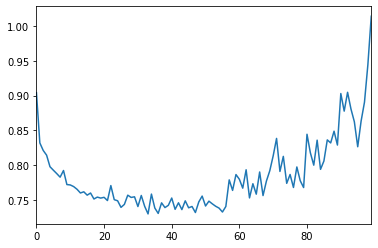

In [0]:
################### DO NOT RUN ###################
bow_ff_nn_predictions_big = []
original_lables_ff_bow_big = []
# ff_nn_bow_model.eval()
with torch.no_grad():
    for index, row in X_test.iterrows():
        bow_vec = make_bow_vector(mydict, row['stemmed_tokens'])
        probs = ff_nn_bow_model_big(bow_vec)
        
        bow_ff_nn_predictions_big.append(torch.argmax(probs, dim=1).cpu().numpy()[0])
        original_lables_ff_bow_big.append(make_target(Y_test['sentiment'][index]).cpu().numpy()[0])
print(classification_report(original_lables_ff_bow_big,bow_ff_nn_predictions_big))

ffnn_loss_df = pd.read_csv(ffnn_loss_file_name)
print(ffnn_loss_df.columns)
ffnn_plt_1000_padding_100_epochs = ffnn_loss_df[' loss'].plot()
fig = ffnn_plt_1000_padding_100_epochs.get_figure()
fig.savefig(OUTPUT_FOLDER + 'plots/' + "ffnn_bow_loss_500_padding_100_epochs.pdf")

### With less LR

In [0]:
################### DO NOT RUN ###################
top_data_df_small = get_top_data(top_n=10000)
top_data_df_small = get_stemmed_tokens(top_data_df_small)
X_train, X_test, Y_train, Y_test = split_train_test(top_data_df_small)
mydict = make_dict(top_data_df_small, padding=False)
VOCAB_SIZE = len(mydict)

input_dim = VOCAB_SIZE
hidden_dim = 500
output_dim = 3
num_epochs = 45

ff_nn_bow_model_big = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)
ff_nn_bow_model_big.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(ff_nn_bow_model_big.parameters(), lr=0.001)

# Open the file for writing loss
ffnn_loss_file_name = OUTPUT_FOLDER + 'ffnn_bow_class_big_loss_500_epoch_45_less_lr.csv'
f = open(ffnn_loss_file_name,'w')
f.write('iter, loss')
f.write('\n')
losses = []
iter = 0
# ff_nn_bow_model.train()
for epoch in range(num_epochs):
    if (epoch+1) % 25 == 0:
        print("Epoch completed: " + str(epoch+1))
    train_loss = 0
    for index, row in X_train.iterrows():
        # Clearing the accumulated gradients
        optimizer.zero_grad()

        # Make the bag of words vector for stemmed tokens 
        bow_vec = make_bow_vector(mydict, row['stemmed_tokens'])
       
        # Forward pass to get output
        probs = ff_nn_bow_model_big(bow_vec)

        # Get the target label
        target = make_target(Y_train['sentiment'][index])

        # Calculate Loss: softmax --> cross entropy loss
        loss = loss_function(probs, target)
        # Accumulating the loss over time
        train_loss += loss.item()

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()
    f.write(str((epoch+1)) + "," + str(train_loss / len(X_train)))
    f.write('\n')
    train_loss = 0

f.close()
    

Value counts for Train sentiments
 1    7036
-1    7008
 0    6956
Name: sentiment, dtype: int64
Value counts for Test sentiments
 0    3044
-1    2992
 1    2964
Name: sentiment, dtype: int64
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
   index  ...                                     stemmed_tokens
0  34963  ...  [wait, minut, onli, to, get, to, front, of, th...
1  21265  ...  [chicken, bacon, ranch, pizza, wa, pretti, bom...
2  36472  ...  [as, sketchi, as, hell, thi, place, strike, me...
3  36589  ...  [last, time, tri, bubbl, tea, and, it, wa, dis...
4   3117  ...  [so, for, the, game, last, week, wa, visit, th...

[5 rows x 11 columns]
Dictionary without padding
Epoch completed: 25


KeyboardInterrupt: ignored

In [0]:
################### DO NOT RUN ###################
bow_ff_nn_predictions_big = []
original_lables_ff_bow_big = []
# ff_nn_bow_model.eval()
with torch.no_grad():
    for index, row in X_test.iterrows():
        bow_vec = make_bow_vector(mydict, row['stemmed_tokens'])
        probs = ff_nn_bow_model_big(bow_vec)
        
        bow_ff_nn_predictions_big.append(torch.argmax(probs, dim=1).cpu().numpy()[0])
        original_lables_ff_bow_big.append(make_target(Y_test['sentiment'][index]).cpu().numpy()[0])
print(classification_report(original_lables_ff_bow_big,bow_ff_nn_predictions_big))


              precision    recall  f1-score   support

           0       0.78      0.76      0.77      2992
           1       0.66      0.65      0.65      3044
           2       0.79      0.82      0.80      2964

    accuracy                           0.74      9000
   macro avg       0.74      0.74      0.74      9000
weighted avg       0.74      0.74      0.74      9000



45
Index(['iter', ' loss'], dtype='object')


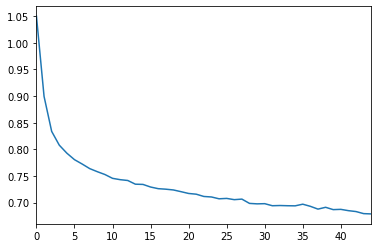

In [0]:
f.close()
ffnn_loss_df = pd.read_csv(ffnn_loss_file_name)
print(len(ffnn_loss_df))
print(ffnn_loss_df.columns)
ffnn_plt_1000_padding_100_epochs = ffnn_loss_df[' loss'].plot()
fig = ffnn_plt_1000_padding_100_epochs.get_figure()
fig.savefig(OUTPUT_FOLDER + 'plots/' + "ffnn_bow_loss_500_padding_45_epochs_less_lr.pdf")

In [0]:
################### DO NOT RUN ###################
top_data_df_small = get_top_data(top_n=10000)
top_data_df_small = get_stemmed_tokens(top_data_df_small)
X_train, X_test, Y_train, Y_test = split_train_test(top_data_df_small)
mydict = make_dict(top_data_df_small, padding=False)
VOCAB_SIZE = len(mydict)

input_dim = VOCAB_SIZE
hidden_dim = 500
output_dim = 3
num_epochs = 100

ff_nn_bow_model_big = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)
ff_nn_bow_model_big.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(ff_nn_bow_model_big.parameters(), lr=0.001)

# Open the file for writing loss
ffnn_loss_file_name = OUTPUT_FOLDER + 'ffnn_bow_class_big_loss_500_epoch_100_less_lr.csv'
f = open(ffnn_loss_file_name,'w')
f.write('iter, loss')
f.write('\n')
losses = []
iter = 0
# ff_nn_bow_model.train()
for epoch in range(num_epochs):
    if (epoch+1) % 25 == 0:
        print("Epoch completed: " + str(epoch+1))
    train_loss = 0
    for index, row in X_train.iterrows():
        # Clearing the accumulated gradients
        optimizer.zero_grad()

        # Make the bag of words vector for stemmed tokens 
        bow_vec = make_bow_vector(mydict, row['stemmed_tokens'])
       
        # Forward pass to get output
        probs = ff_nn_bow_model_big(bow_vec)

        # Get the target label
        target = make_target(Y_train['sentiment'][index])

        # Calculate Loss: softmax --> cross entropy loss
        loss = loss_function(probs, target)
        # Accumulating the loss over time
        train_loss += loss.item()

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()
    f.write(str((epoch+1)) + "," + str(train_loss / len(X_train)))
    f.write('\n')
    train_loss = 0

f.close()
    

Value counts for Train sentiments
 1    7036
-1    7008
 0    6956
Name: sentiment, dtype: int64
Value counts for Test sentiments
 0    3044
-1    2992
 1    2964
Name: sentiment, dtype: int64
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
   index  ...                                     stemmed_tokens
0  34963  ...  [wait, minut, onli, to, get, to, front, of, th...
1  21265  ...  [chicken, bacon, ranch, pizza, wa, pretti, bom...
2  36472  ...  [as, sketchi, as, hell, thi, place, strike, me...
3  36589  ...  [last, time, tri, bubbl, tea, and, it, wa, dis...
4   3117  ...  [so, for, the, game, last, week, wa, visit, th...

[5 rows x 11 columns]
Dictionary without padding
Epoch completed: 25
Epoch completed: 50
Epoch completed: 75
Epoch completed: 100


              precision    recall  f1-score   support

           0       0.80      0.72      0.76      2992
           1       0.64      0.69      0.66      3044
           2       0.79      0.81      0.80      2964

    accuracy                           0.74      9000
   macro avg       0.75      0.74      0.74      9000
weighted avg       0.74      0.74      0.74      9000

100
Index(['iter', ' loss'], dtype='object')


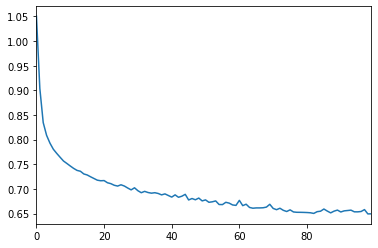

In [0]:
################### DO NOT RUN ###################
bow_ff_nn_predictions_big = []
original_lables_ff_bow_big = []
# ff_nn_bow_model.eval()
with torch.no_grad():
    for index, row in X_test.iterrows():
        bow_vec = make_bow_vector(mydict, row['stemmed_tokens'])
        probs = ff_nn_bow_model_big(bow_vec)
        
        bow_ff_nn_predictions_big.append(torch.argmax(probs, dim=1).cpu().numpy()[0])
        original_lables_ff_bow_big.append(make_target(Y_test['sentiment'][index]).cpu().numpy()[0])
print(classification_report(original_lables_ff_bow_big,bow_ff_nn_predictions_big))
ffnn_loss_df = pd.read_csv(ffnn_loss_file_name)
print(len(ffnn_loss_df))
print(ffnn_loss_df.columns)
ffnn_plt_1000_padding_100_epochs = ffnn_loss_df[' loss'].plot()
fig = ffnn_plt_1000_padding_100_epochs.get_figure()
fig.savefig(OUTPUT_FOLDER + 'plots/' + "ffnn_bow_loss_500_padding_100_epochs_less_lr.pdf")

# Task 9: Classification with CNN
## CNN

A Convolutional Neural Network (CNN) involves two operations, which can be thought of as feature extractors: convolution and pooling. Output of these operations is finally connected to the multi-layer perceptron to get the final output. 

In convolutional layer, instead of mulitplying the filters on the small regions of the images, it slides through embedding vectors of few words as mentioned by window size. For looking at sequences of word embeddings, the window has to look at multiple word embeddings in a sequence. They will be rectangular with size `window_size * embedding_size`. This is similar to n-grams where some length of words are taken together as features.  The kernel weights (filter) are multiplied to word embeddings in pairs and summed up to get output values. As the network is training these kernel weights are updated. Output value essentially tries to get a representative value for the phrase. The convolution filters tries to extract features like sentiment of the phrases, grammatical functions of the words, and so on. 

In case of images, the inputs for different pigment is given seperately in which case the number of input channels are 3 if RGB or 1 if it is a grey scale. In this case, we are feeding only one feature i.e. word embeddings so the first parameter for `conv2d` is `1` and output_channels is total number of features which will be `NUM_FILTERS`. Then the `kernel_size` is provided which is the `window_size * embedding_size`. Padding is given `window_size-1`. All these feature outputs are concatenated and passed through linear layer to get the probabilities of the classes. 

Embedding vectors from the word2vec model are fed to the network and padding_idx is also added where the length of the sentence is smaller than the longest sentence. This is because the input is the `longest_len_of_sentence * embedding_size`. This padding index can be mentioned in the `from_pretrained` function where it indicates that we are feeding already trained word2vec model vectors. 

Explanation: https://cezannec.github.io/CNN_Text_Classification/

In [0]:
################### DO NOT RUN ###################
EMBEDDING_SIZE = 500
NUM_FILTERS = 10
PAD_TOKEN = '<PAD>'
import gensim

class CnnTextClassifier(nn.Module):
    def __init__(self, vocab_size, num_classes, window_sizes=(1,2,3,5)):
        super(CnnTextClassifier, self).__init__()
        w2vmodel = gensim.models.KeyedVectors.load(INPUT_FOLDER + 'models/' + 'word2vec_500_PAD.model')
        weights = w2vmodel.wv
        # With pretrained embeddings
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(weights.vectors), padding_idx=w2vmodel.wv.vocab['pad'].index)
        # Without pretrained embeddings
        # self.embedding = nn.Embedding(vocab_size, EMBEDDING_SIZE)

        self.convs = nn.ModuleList([
                                   nn.Conv2d(1, NUM_FILTERS, [window_size, EMBEDDING_SIZE], padding=(window_size - 1, 0))
                                   for window_size in window_sizes
        ])

        self.fc = nn.Linear(NUM_FILTERS * len(window_sizes), num_classes)

    def forward(self, x):
        x = self.embedding(x) # [B, T, E]

        # Apply a convolution + max_pool layer for each window size
        x = torch.unsqueeze(x, 1)
        xs = []
        for conv in self.convs:
            x2 = torch.tanh(conv(x))
            x2 = torch.squeeze(x2, -1)
            x2 = F.max_pool1d(x2, x2.size(2))
            xs.append(x2)
        x = torch.cat(xs, 2)

        # FC
        x = x.view(x.size(0), -1)
        logits = self.fc(x)

        probs = F.softmax(logits, dim = 1)

        return probs

In [0]:
################### DO NOT RUN ###################
from torch import autograd

import datetime


top_data_df_small = get_top_data(top_n=10000)
top_data_df_small = get_stemmed_tokens(top_data_df_small)
X_train, X_test, Y_train, Y_test = split_train_test(top_data_df_small)
mydict = make_dict(top_data_df_small, padding=True)

w2vmodel = gensim.models.KeyedVectors.load(INPUT_FOLDER + 'models/' + 'word2vec_500_PAD.model')
padding_idx = w2vmodel.wv.vocab['pad'].index

NUM_CLASSES = 3
VOCAB_SIZE = len(w2vmodel.wv.vocab)

cnn_model = CnnTextClassifier(vocab_size=VOCAB_SIZE, num_classes=NUM_CLASSES)
cnn_model.to(device)


loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
num_epochs = 30

now = datetime.datetime.now()
max_sen_len = top_data_df_small.stemmed_tokens.map(len).max()
print("Max Length of the sentences in the data is:" + str(max_sen_len))

def make_bow_vector_cnn(mydict, sentence):
    vec = torch.zeros(VOCAB_SIZE, dtype=torch.long, device=device)
    for word in sentence:
        vec[mydict.token2id[word]] += 1
    return vec.view(1, -1)


def make_word2vec_vector_cnn(sentence):
    padded_X = [padding_idx for i in range(max_sen_len)]
    i = 0
    for word in sentence:
        if word not in w2vmodel.wv.vocab:
            padded_X[i] = 0
            print(word)
        else:
            padded_X[i] = w2vmodel.wv.vocab[word].index
        i += 1
    return torch.tensor(padded_X, dtype=torch.long, device=device).view(1, -1)

def map_word_vocab(sentence):
    idx = [cnn_dict.token2id[word] for word in sentence]
    padded_X = [cnn_dict.token2id[PAD_TOKEN] for x in range(max_sen_len) ]

    padded_X[0: len(sentence)] = idx[:len(idx)]

    return torch.tensor(padded_X, dtype=torch.long, device=device).view(1, -1)


# Open the file for writing loss
loss_file_name = OUTPUT_FOLDER +  'plots/' + 'cnn_class_big_loss_with_padding.csv'
f = open(loss_file_name,'w')
f.write('iter, loss')
f.write('\n')
losses = []
cnn_model.train()
for epoch in range(num_epochs):
    print("Epoch" + str(epoch + 1))
    train_loss = 0
    for index, row in X_train.iterrows():
        # Clearing the accumulated gradients
        cnn_model.zero_grad()

        # Make the bag of words vector for stemmed tokens 
        bow_vec = make_word2vec_vector_cnn(row['stemmed_tokens'])
       
        # Forward pass to get output
        probs = cnn_model(bow_vec)

        # Get the target label
        target = make_target(Y_train['sentiment'][index])

        # Calculate Loss: softmax --> cross entropy loss
        loss = loss_function(probs, target)
        train_loss += loss.item()

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()


    # if index == 0:
    #     continue
    print("Epoch ran :"+ str(epoch+1))
    f.write(str((epoch+1)) + "," + str(train_loss / len(X_train)))
    f.write('\n')
    train_loss = 0

torch.save(cnn_model, OUTPUT_FOLDER + 'cnn_big_model_500_with_padding.pth')

f.close()
print("Input vector")
print(bow_vec.cpu().numpy())
print("Probs")
print(probs)
print(torch.argmax(probs, dim=1).cpu().numpy()[0])

print("Time taken to finish training")
print(datetime.datetime.now() - now)
print(datetime)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Max Length of the sentences in the data is:927
Epoch1
EPoch RAN :0
Epoch2
EPoch RAN :1
Epoch3
EPoch RAN :2
Epoch4
EPoch RAN :3
Epoch5
EPoch RAN :4
Epoch6
EPoch RAN :5
Epoch7
EPoch RAN :6
Epoch8
EPoch RAN :7
Epoch9
EPoch RAN :8
Epoch10
EPoch RAN :9
Epoch11
EPoch RAN :10
Epoch12
EPoch RAN :11
Epoch13
EPoch RAN :12
Epoch14
EPoch RAN :13
Epoch15
EPoch RAN :14
Epoch16
EPoch RAN :15
Epoch17
EPoch RAN :16
Epoch18
EPoch RAN :17
Epoch19
EPoch RAN :18
Epoch20
EPoch RAN :19
Epoch21
EPoch RAN :20
Epoch22
EPoch RAN :21
Epoch23
EPoch RAN :22
Epoch24
EPoch RAN :23
Epoch25
EPoch RAN :24
Epoch26
EPoch RAN :25
Epoch27
EPoch RAN :26
Epoch28
EPoch RAN :27
Epoch29
EPoch RAN :28
Epoch30
EPoch RAN :29
Input vector
[[  393   507     1   323    16    18   107    32     2   716   210   396
    152   110   324 15345 20660    53     0  1063    30     3    59     2
    686     4    16  6547 12832 20661  7510   221     0   197   325   154
      1 15346     8   603     2  1704   325   952   329     7   197   687
   

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type CnnTextClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Embedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ModuleList. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib

NameError: ignored

# Evaluate CNN model

In [0]:
################### DO NOT RUN ###################
bow_cnn_predictions = []
original_lables_cnn_bow = []
# checkpoint = torch.load('/content/drive/My Drive/CodePub/cnn_big_model.pth')
# cnn_model_loaded = CnnTextClassifier(VOCAB_SIZE, NUM_CLASSES)
# torch.save(cnn_model, '/content/drive/My Drive/CodePub/cnn_big_model.pth')
# cnn_model_loaded = torch.load('/content/drive/My Drive/CodePub/cnn_big_model.pth')

cnn_model.eval()
f.close()
loss_df = pd.read_csv(INPUT_FOLDER + 'cnn_class_big_loss_with_padding.csv')
print(loss_df.columns)
# loss_df.plot('loss')
with torch.no_grad():
    for index, row in X_test.iterrows():
        bow_vec = make_word2vec_vector_cnn(row['stemmed_tokens'])
        probs = cnn_model(bow_vec)
        _, predicted = torch.max(probs.data, 1)
        bow_cnn_predictions.append(predicted.cpu().numpy()[0])
        # bow_cnn_predictions.append(torch.argmax(probs, dim=1).cpu().numpy()[0])
        original_lables_cnn_bow.append(make_target(Y_test['sentiment'][index]).cpu().numpy()[0])
print(bow_vec.cpu().numpy())
print(probs)
print(classification_report(original_lables_cnn_bow,bow_cnn_predictions))

Index(['iter', ' loss'], dtype='object')
[[  19   18   65    2  719 7390    6  172  694   60  316   90    0  335
  1021    0  477    5  126  128    4    3   37  580   13 1036  119   13
    27  273   18  106   38   13  377    2   39  638   55 4680  168   63
     7  942    6  313  283 1231  695    3   50   14  199   26  194   10
  3495  719 7390   88  199   69   26   10   27 1049    1  126 2683 1083
  1083 1083 1083 1083 1083 1083 1083 1083 1083 1083 1083 1083 1083 1083
  1083 1083 1083 1083 1083 1083 1083 1083 1083 1083 1083 1083 1083 1083
  1083 1083 1083 1083 1083 1083 1083 1083 1083 1083 1083 1083 1083 1083
  1083 1083 1083 1083 1083 1083 1083 1083 1083 1083 1083 1083 1083 1083
  1083 1083 1083 1083 1083 1083 1083 1083 1083 1083 1083 1083 1083 1083
  1083 1083 1083 1083 1083 1083 1083 1083 1083 1083 1083 1083 1083 1083
  1083 1083 1083 1083 1083 1083 1083 1083 1083 1083 1083 1083 1083 1083
  1083 1083 1083 1083 1083 1083 1083 1083 1083 1083 1083 1083 1083 1083
  1083 1083 1083 1083 1

# Plotting the loss

Index(['iter', ' loss'], dtype='object')


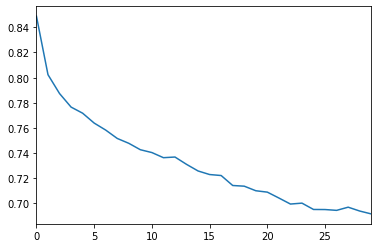

In [0]:
################### DO NOT RUN ###################
# print(predicted.cpu().numpy()[0])
# print(original_lables_cnn_bow)
# print(probs)
import pandas as pd
loss_file_name = INPUT_FOLDER +  'plots/' + 'cnn_class_big_loss_with_padding.csv'
loss_df = pd.read_csv(loss_file_name)
print(loss_df.columns)
plt_500_padding_30_epochs = loss_df[' loss'].plot()
# print(target)
# w2vmodel = gensim.models.KeyedVectors.load('/content/drive/My Drive/CodePub/word2vec_500.model')
# w2vmodel.wv.vectors


In [0]:
################### DO NOT RUN ###################
fig = plt_500_padding_30_epochs.get_figure()
fig.savefig(OUTPUT_FOLDER +'plots/' + 'loss_plt_500_padding_30_epochs.pdf")

# Task 10: Visualizing Word embeddings 
## Visualize the embeddings



In [0]:
import numpy as np
import gensim
#Important Parameters
w2vmodel = gensim.models.KeyedVectors.load(INPUT_FODLER + 'models/' + 'word2vec_500_PAD.model')

NUM_CLASSES = 3
VOCAB_SIZE = len(w2vmodel.wv.vocab)
print(VOCAB_SIZE)
EMBEDDING_DIM = w2vmodel["is"].shape[0]
print(EMBEDDING_DIM)
# w2v = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))


tsv_file_path = INPUT_FOLDER + "tensorboard/" + "metadata1.tsv"
tsv_file_vectors_path = INPUT_FOLDER + "tensorboard/" +"vects1.tsv"
file_metadata = open(tsv_file_path,'w+', encoding='utf-8')
file_vectors = open(tsv_file_vectors_path, 'w+', encoding='utf-8')
for i,word in enumerate(w2vmodel.wv.index2word[:VOCAB_SIZE]):
    # w2v[i] = w2vmodel[word]
    file_metadata.write(word+'\n')
    file_vectors.write('\t'.join([str(x) for x in w2vmodel[word]]) + "\n")
file_metadata.close()
file_vectors.close()

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


30056
500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



## That's all for this workshop! Keep Experimenting :) 